# Shortest path along network

Based on https://automating-gis-processes.github.io/site/notebooks/L6/network-analysis.html

In [1]:
#import
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

## The network

In [2]:
# configure the place, network type, trip times, and travel speed
place = 'Moonee Ponds, Victoria, Australia'
# download the street network
G = ox.graph_from_place(place, network_type="walk")

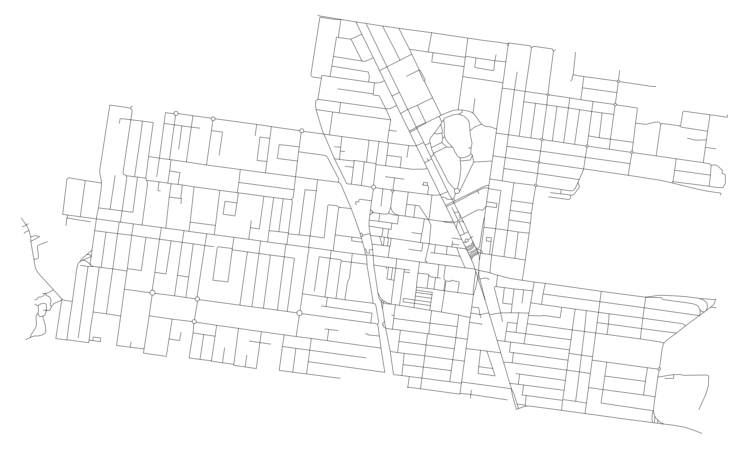

In [3]:
#plot
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
plt.show()

In [4]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [5]:
# Check columns
edges.columns

Index(['access', 'bridge', 'geometry', 'highway', 'junction', 'key', 'lanes',
       'length', 'maxspeed', 'name', 'oneway', 'osmid', 'ref', 'service',
       'tunnel', 'u', 'v', 'width'],
      dtype='object')

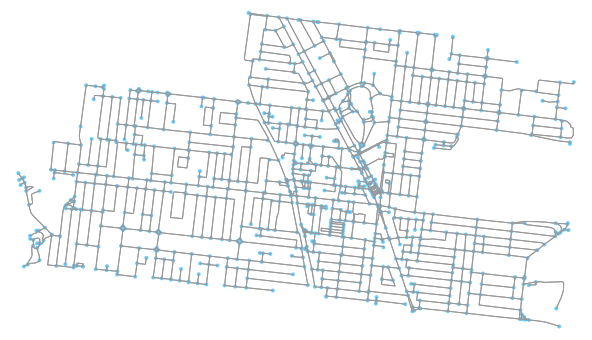

In [6]:
graph_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(graph_proj)

In [7]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [8]:
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=55 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [9]:
edges_proj.head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,LINESTRING (316842.8385048772 -4181674.5192269...,tertiary,NaN,0,NaN,65.097,50,Eddy Street,False,8738208,NaN,NaN,NaN,62660608,62665250,NaN
1,NaN,NaN,LINESTRING (316842.8385048772 -4181674.5192269...,tertiary,NaN,0,NaN,14.386,50,Eddy Street,False,8738208,NaN,NaN,NaN,62660608,62656777,NaN
2,NaN,NaN,LINESTRING (316842.8385048772 -4181674.5192269...,tertiary,NaN,0,NaN,15.359,50,Eddy Street,False,8739112,NaN,NaN,NaN,62660608,62660607,NaN
3,NaN,NaN,LINESTRING (316803.8320474022 -4182156.4739191...,tertiary,NaN,0,NaN,8.731,NaN,Moore Street,False,8504222,NaN,NaN,NaN,62750722,62750715,NaN
4,NaN,NaN,LINESTRING (316803.8320474022 -4182156.4739191...,tertiary,NaN,0,NaN,31.026,NaN,Moore Street,False,8504222,NaN,NaN,NaN,62750722,62748954,NaN


In [10]:
nodes_proj.head()

,highway,lat,lon,osmid,ref,x,y,geometry
62660608,NaN,-37.764070,144.920624,62660608,NaN,316842.838505,-4.181675e+06,POINT (316842.8385048772 -4181674.519226995)
62750722,NaN,-37.768403,144.920060,62750722,NaN,316803.832047,-4.182156e+06,POINT (316803.8320474022 -4182156.473919127)
75008015,NaN,-37.760175,144.928505,75008015,NaN,317527.591200,-4.181227e+06,POINT (317527.5911997624 -4181226.864433633)
75008016,NaN,-37.760161,144.928399,75008016,NaN,317518.156592,-4.181226e+06,POINT (317518.1565918489 -4181225.508021425)
2516168720,NaN,-37.758681,144.924291,2516168720,NaN,317152.636155,-4.181069e+06,POINT (317152.6361546778 -4181069.335377383)


## The origin and destination

In [11]:
#origin coordinates
origin_coords = (-37.764914, 144.924148) # Sam Merrifield Library
#origin node
orig_node = ox.get_nearest_node(G, (origin_coords[0], origin_coords[1]), method='euclidean')
orig_node

67871773

In [12]:
#destination coordinates
target_coords = (-37.765940, 144.919523) # Moonee Ponds Station
target_node = ox.get_nearest_node(G, (target_coords[0], target_coords[1]), method='euclidean')
target_node

62673046

In [13]:
# Retrieve Shapely Point geometry out of it
origin = nodes_proj.loc[nodes_proj.index==orig_node, 'geometry'].values[0]
print(origin)

target = nodes_proj.loc[nodes_proj.index==target_node, 'geometry'].values[0]
print(target)

POINT (317143.8537034823 -4181764.45282488)
POINT (316749.3634331123 -4181864.767728471)


In [14]:
# Get origin x and y coordinates
orig_xy = (origin.y, origin.x)

# Get target x and y coordinates
target_xy = (target.y, target.x)

In [15]:
# Retrieve the rows from the nodes GeoDataFrame
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]

In [16]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,highway,lat,lon,osmid,ref,x,y,geometry
67871773,NaN,-37.764940,144.924016,67871773,NaN,317143.853703,-4.181764e+06,POINT (317143.8537034823 -4181764.45282488)
62673046,NaN,-37.765765,144.919515,62673046,NaN,316749.363433,-4.181865e+06,POINT (316749.3634331123 -4181864.767728471)


## The shortest path

In [17]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

# Show what we have
print(route)

[67871773, 4254272748, 67871630, 6091216115, 280172322, 2404817775, 62675855, 62675345, 62675858, 280400563, 2430664203, 6720805913, 2430664202, 2430664201, 280400562, 62673046]


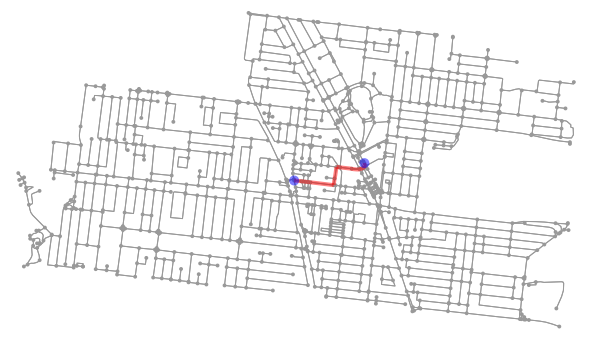

In [18]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route, origin_point=orig_xy, destination_point=target_xy)

## Just the distances

In [19]:
#just the distance
length = nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_node, weight='length')
print(str(length) + " metres") 

512.299 metres


In [20]:
#the short way of doing it. No map
import networkx as nx
import osmnx as ox
graph = ox.graph_from_place('Moonee Ponds, Victoria, Australia', network_type='walk', simplify=True)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
orig_node = ox.get_nearest_node(graph, (-37.764914, 144.924148)) # Sam Merrifield Library
target_node = ox.get_nearest_node(graph, (-37.765940, 144.919523)) # Moonee Ponds Station
length = nx.shortest_path_length(G=graph, source=orig_node, target=target_node, weight='length')
print(str(length) + " metres") 

512.299 metres


## Import shapefiles and do it

In [21]:
# irrigated parks in 28355
# Set filepath
origin_fp = r"shp\in\test_origins.shp"
# Read file using gpd.read_file()
origin_shp = gpd.read_file(origin_fp)

# Set filepath
target_fp = r"shp\in\test_destinations.shp"
# Read file using gpd.read_file()
target_shp = gpd.read_file(target_fp)

In [22]:
# original data - crs
print(origin_shp.crs)
#reproject to WGS84 - copy of data
origin_shp_proj = origin_shp.to_crs(epsg=4326)
print(origin_shp_proj.crs)
print(origin_shp_proj.head())

{'init': 'epsg:28355'}
{'init': 'epsg:4326', 'no_defs': True}
     id                           site           type         cat  \
0  P150       Grandview Street Reserve    Small Local  Open Space   
1  P285            Steele Street Steps    Small Local     Walkway   
2  P694  Mt Alexander Road, Travancore  Neighbourhood       Roads   

                         feat_loc         nhood  \
0                            None  Moonee Ponds   
1                            None  Moonee Ponds   
2  Triangle Moonee Ponds Junction  Moonee Ponds   

                                       geometry  
0   POINT (144.9133474914989 -37.7677126263125)  
1   POINT (144.930266902384 -37.76960866764276)  
2  POINT (144.9247592497133 -37.76672416870112)  


In [23]:
# original data - crs
print(target_shp.crs)
#reproject to WGS84 - copy of data
target_shp_proj = target_shp.to_crs(epsg=4326)
print(target_shp_proj.crs)
print(target_shp_proj.head())

{'init': 'epsg:28355'}
{'init': 'epsg:4326', 'no_defs': True}
     id       type   irrigation                                      geometry
0  P566  Municipal  Mains water   POINT (144.935113620916 -37.77226702803973)
1  P681   Regional  Mains water  POINT (144.9239984549996 -37.76256297333828)


In [24]:
#origin list within a list
origin_list_a = [list(origin_shp_proj['geometry'].geometry[row_id].coords) for row_id in range(origin_shp_proj['geometry'].shape[0])] 

#proper format but in long, lat (not right for this)
origin_list_b = []
for i in origin_list_a:
    origin_list_b.append(i[0])

# proper but in lat, long 
origin_list_c = []
for i in origin_list_b:
    lat_long = []
    lat_long.append(i[1])
    lat_long.append(i[0])
    origin_list_c.append(lat_long)
    
print(origin_list_c)

[[-37.7677126263125, 144.91334749149894], [-37.76960866764276, 144.93026690238403], [-37.76672416870112, 144.92475924971328]]


In [25]:
#target list within a list
target_list_a = [list(target_shp_proj['geometry'].geometry[row_id].coords) for row_id in range(target_shp_proj['geometry'].shape[0])] 

#proper format but in long, lat (not right for this)
target_list_b = []
for i in target_list_a:
    target_list_b.append(i[0])

# proper but in lat, long 
target_list_c = []
for i in target_list_b:
    lat_long = []
    lat_long.append(i[1])
    lat_long.append(i[0])
    target_list_c.append(lat_long)
    
print(target_list_c)

[[-37.77226702803973, 144.935113620916], [-37.76256297333828, 144.92399845499963]]


In [26]:
#function to get nearest nodes
def short_path_multiple(origin_list, destination_list):
    origin_nodes = []
    destination_nodes = []
    for i in origin_list:
        x = ox.get_nearest_node(graph, (i[0], i[1]))
        origin_nodes.append(x)
    for j in destination_list:
        x = ox.get_nearest_node(graph, (j[0], j[1]))
        destination_nodes.append(x)
    return origin_nodes, destination_nodes

nodes_exp = short_path_multiple(origin_list_c, target_list_c) #no need to change the variables
origin_nodes = nodes_exp[0]
target_nodes = nodes_exp[1]
print(origin_nodes)
print(target_nodes)

[2506726076, 1607351559, 4254177498]
[2092982666, 1080086058]


In [36]:
#function to calculate the distances
def multiple_path_calcs(origins, destinations):
    node_table = {'origin':[], 'destination':[], 'distance': []}
    for i in origin_nodes:
        for j in target_nodes:
            length = nx.shortest_path_length(G=graph, source=i, target=j, weight='length')
            node_table['origin'].append(i)
            node_table['destination'].append(j)
            node_table['distance'].append(length)
    return node_table

#run the function and put in data frame
multiple_a = multiple_path_calcs(origin_nodes, target_nodes) # no need to change the variables
multiple_b = pd.DataFrame.from_dict(multiple_a)
multiple_b

,origin,destination,distance
0,2506726076,2092982666,2801.335
1,2506726076,1080086058,1653.349
2,1607351559,2092982666,887.753
3,1607351559,1080086058,1225.752
4,4254177498,2092982666,1552.154
5,4254177498,1080086058,511.538


## The origins and destinations

In [38]:
origin_tuple = zip(origin_shp['id'], origin_nodes) #where 'id' is UID the column in the shapefile
origin_tuple = (list(origin_tuple))
origin_df = pd.DataFrame(origin_tuple, columns =['origin_id', 'origin'])
origin_df

,origin_id,origin
0,P150,2506726076
1,P285,1607351559
2,P694,4254177498


In [46]:
target_tuple = zip(target_shp['id'], target_nodes) #where 'id' is UID the column in the shapefile
target_tuple = (list(target_tuple))
target_df = pd.DataFrame(target_tuple, columns =['destination_id', 'destination'])
target_df

,destination_id,destination
0,P566,2092982666
1,P681,1080086058


In [47]:
#join the tables
join1 = multiple_b.join(origin_df.set_index('origin'), on='origin')
join2 = join1.join(target_df.set_index('destination'), on='destination')
join2

,origin,destination,distance,origin_id,destination_id
0,2506726076,2092982666,2801.335,P150,P566
1,2506726076,1080086058,1653.349,P150,P681
2,1607351559,2092982666,887.753,P285,P566
3,1607351559,1080086058,1225.752,P285,P681
4,4254177498,2092982666,1552.154,P694,P566
5,4254177498,1080086058,511.538,P694,P681


In [49]:
shortest_dist_by_origin = (join2.sort_values('distance', ascending=True)
        .groupby(['origin_id'], sort=False).head(1))
shortest_dist_by_origin

,origin,destination,distance,origin_id,destination_id
5,4254177498,1080086058,511.538,P694,P681
2,1607351559,2092982666,887.753,P285,P566
1,2506726076,1080086058,1653.349,P150,P681
